In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines
%matplotlib inline
from sklearn import preprocessing 
from sklearn import datasets, linear_model
#from sklearn.preprocessing import StandardScaler
#will use min max scaler
#from sklearn.model_selection import train_test_split
#from sklearn.tree import DecisionTreeRegressor
#from sklearn.ensemble import RandomForestRegressor

#from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold 
#from sklearn.metrics import mean_squared_error
#from sklearn.model_selection import cross_val_score

In [2]:
#reading the dataset
df = pd.read_csv("training.1600000.processed.noemoticon.csv",encoding='latin-1')

In [3]:
df.columns = ['sentiment','id','date',
                     'query_type','user','tweet']

In [4]:
df.head()

,sentiment,id,date,query_type,user,tweet
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [5]:
df.tail()

,sentiment,id,date,query_type,user,tweet
1599994,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599995,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599996,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599997,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...
1599998,4,2193602129,Tue Jun 16 08:40:50 PDT 2009,NO_QUERY,RyanTrevMorris,happy #charitytuesday @theNSPCC @SparksCharity...


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599999 entries, 0 to 1599998
Data columns (total 6 columns):
sentiment     1599999 non-null int64
id            1599999 non-null int64
date          1599999 non-null object
query_type    1599999 non-null object
user          1599999 non-null object
tweet         1599999 non-null object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [7]:
df.isnull().sum()

sentiment     0
id            0
date          0
query_type    0
user          0
tweet         0
dtype: int64

In [8]:
df.sentiment.value_counts()

4    800000
0    799999
Name: sentiment, dtype: int64

In [9]:
df.drop(['date','query_type','user'],axis=1,inplace=True)

In [10]:
df[df.sentiment == 0].head(10)

,sentiment,id,tweet
0,0,1467810672,is upset that he can't update his Facebook by ...
1,0,1467810917,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,my whole body feels itchy and like its on fire
3,0,1467811193,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,@Kwesidei not the whole crew
5,0,1467811592,Need a hug
6,0,1467811594,@LOLTrish hey long time no see! Yes.. Rains a...
7,0,1467811795,@Tatiana_K nope they didn't have it
8,0,1467812025,@twittera que me muera ?
9,0,1467812416,spring break in plain city... it's snowing


In [11]:
df[df.sentiment == 4].head(10)

,sentiment,id,tweet
799999,4,1467822272,I LOVE @Health4UandPets u guys r the best!!
800000,4,1467822273,im meeting up with one of my besties tonight! ...
800001,4,1467822283,"@DaRealSunisaKim Thanks for the Twitter add, S..."
800002,4,1467822287,Being sick can be really cheap when it hurts t...
800003,4,1467822293,@LovesBrooklyn2 he has that effect on everyone
800004,4,1467822391,@ProductOfFear You can tell him that I just bu...
800005,4,1467822447,@r_keith_hill Thans for your response. Ihad al...
800006,4,1467822465,"@KeepinUpWKris I am so jealous, hope you had a..."
800007,4,1467822489,"@tommcfly ah, congrats mr fletcher for finally..."
800008,4,1467822496,@e4VoIP I RESPONDED Stupid cat is helping me ...


In [12]:
df['length'] = [len(t) for t in df.tweet]

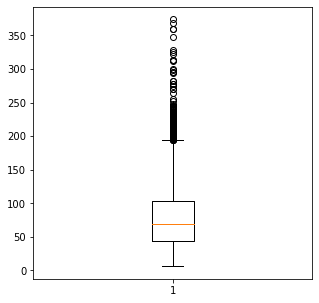

In [13]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.boxplot(df.length)
plt.show()

In [14]:
#since Twitter Maximum Character Length is 280 so we remove the tweets beyondthat limit
df.drop(df[df['length'] > 280].index, inplace = True) 

In [15]:
#Converting html entities
from html.parser import HTMLParser
html_parser = HTMLParser()
# Created a new columns i.e. clean_tweet contains the same tweets but cleaned version
df['clean_tweet'] = df['tweet'].apply(lambda x: html_parser.unescape(x))

C:\Users\KIIT\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  """


In [16]:
import re
#Removing "@user" from all the tweets
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
    return input_txt
# remove twitter handles (@user)
df['clean_tweet'] = np.vectorize(remove_pattern)(df['clean_tweet'], "@[\w]*")
df.head(10)

,sentiment,id,tweet,length,clean_tweet
0,0,1467810672,is upset that he can't update his Facebook by ...,111,is upset that he can't update his Facebook by ...
1,0,1467810917,@Kenichan I dived many times for the ball. Man...,89,I dived many times for the ball. Managed to s...
2,0,1467811184,my whole body feels itchy and like its on fire,47,my whole body feels itchy and like its on fire
3,0,1467811193,"@nationwideclass no, it's not behaving at all....",111,"no, it's not behaving at all. i'm mad. why am..."
4,0,1467811372,@Kwesidei not the whole crew,29,not the whole crew
5,0,1467811592,Need a hug,11,Need a hug
6,0,1467811594,@LOLTrish hey long time no see! Yes.. Rains a...,99,"hey long time no see! Yes.. Rains a bit ,onl..."
7,0,1467811795,@Tatiana_K nope they didn't have it,36,nope they didn't have it
8,0,1467812025,@twittera que me muera ?,25,que me muera ?
9,0,1467812416,spring break in plain city... it's snowing,43,spring break in plain city... it's snowing


In [17]:
#Changing all the tweets into lowercase
df['clean_tweet'] = df['clean_tweet'].apply(lambda x: x.lower())
df.head(10)

,sentiment,id,tweet,length,clean_tweet
0,0,1467810672,is upset that he can't update his Facebook by ...,111,is upset that he can't update his facebook by ...
1,0,1467810917,@Kenichan I dived many times for the ball. Man...,89,i dived many times for the ball. managed to s...
2,0,1467811184,my whole body feels itchy and like its on fire,47,my whole body feels itchy and like its on fire
3,0,1467811193,"@nationwideclass no, it's not behaving at all....",111,"no, it's not behaving at all. i'm mad. why am..."
4,0,1467811372,@Kwesidei not the whole crew,29,not the whole crew
5,0,1467811592,Need a hug,11,need a hug
6,0,1467811594,@LOLTrish hey long time no see! Yes.. Rains a...,99,"hey long time no see! yes.. rains a bit ,onl..."
7,0,1467811795,@Tatiana_K nope they didn't have it,36,nope they didn't have it
8,0,1467812025,@twittera que me muera ?,25,que me muera ?
9,0,1467812416,spring break in plain city... it's snowing,43,spring break in plain city... it's snowing


In [18]:
# Apostrophe Dictionary
apostrophe_dict = {
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not","couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is",
"i'd": "I would",
"i'd've": "I would have",
"i'll": "I will",
"i'll've": "I will have",
"i'm": "I am",
"i've": "I have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have","mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had","that'd've": "that would have",
"that's": "that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will","we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have","who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}

In [19]:
def lookup_dict(text, dictionary):
    for word in text.split():
        if word.lower() in dictionary:
            if word.lower() in text.split():
                text = text.replace(word, dictionary[word.lower()])
    return text

In [20]:
df['clean_tweet'] = df['clean_tweet'].apply(lambda x: lookup_dict(x,apostrophe_dict))

In [21]:
short_word_dict = {
"121": "one to one",
"a/s/l": "age, sex, location",
"adn": "any day now",
"afaik": "as far as I know",
"afk": "away from keyboard",
"aight": "alright",
"alol": "actually laughing out loud",
"b4": "before",
"b4n": "bye for now",
"bak": "back at the keyboard",
"bf": "boyfriend",
"bff": "best friends forever",
"bfn": "bye for now",
"bg": "big grin",
"bta": "but then again",
"btw": "by the way",
"cid": "crying in disgrace","cnp": "continued in my next post",
"cp": "chat post",
"cu": "see you",
"cul": "see you later",
"cul8r": "see you later",
"cya": "bye",
"cyo": "see you online",
"dbau": "doing business as usual",
"fud": "fear, uncertainty, and doubt",
"fwiw": "for what it's worth",
"fyi": "for your information",
"g": "grin",
"g2g": "got to go",
"ga": "go ahead",
"gal": "get a life",
"gf": "girlfriend","gfn": "gone for now",
"gmbo": "giggling my butt off",
"gmta": "great minds think alike",
"h8": "hate",
"hagn": "have a good night",
"hdop": "help delete online predators",
"hhis": "hanging head in shame",
"iac": "in any case",
"ianal": "I am not a lawyer",
"ic": "I see",
"idk": "I don't know",
"imao": "in my arrogant opinion",
"imnsho": "in my not so humble opinion",
"imo": "in my opinion",
"iow": "in other words",
"ipn": "I’m posting naked","irl": "in real life",
"jk": "just kidding",
"l8r": "later",
"ld": "later, dude",
"ldr": "long distance relationship",
"llta": "lots and lots of thunderous applause",
"lmao": "laugh my ass off",
"lmirl": "let's meet in real life",
"lol": "laugh out loud",
"ltr": "longterm relationship",
"lulab": "love you like a brother",
"lulas": "love you like a sister",
"luv": "love",
"m/f": "male or female","m8": "mate",
"milf": "mother I would like to fuck",
"oll": "online love",
"omg": "oh my god",
"otoh": "on the other hand",
"pir": "parent in room",
"ppl": "people",
"r": "are",
"rofl": "roll on the floor laughing",
"rpg": "role playing games",
"ru": "are you",
"shid": "slaps head in disgust",
"somy": "sick of me yet",
"sot": "short of time",
"thanx": "thanks",
"thx": "thanks",
"ttyl": "talk to you later",
"u": "you",
"ur": "you are",
"uw": "you’re welcome",
"wb": "welcome back",
"wfm": "works for me",
"wibni": "wouldn't it be nice if","wtf": "what the fuck",
"wtg": "way to go",
"wtgp": "want to go private",
"ym": "young man",
"gr8": "great"
}

In [22]:
df['clean_tweet'] = df['clean_tweet'].apply(lambda x: lookup_dict(x,short_word_dict))

In [23]:
emoticon_dict = {
":)": "happy",
":‑)": "happy",
":-]": "happy",
":-3": "happy",
":->": "happy",
"8-)": "happy",
":-}": "happy",
":o)": "happy",
":c)": "happy",
":^)": "happy",
"=]": "happy",
"=)": "happy",
"<3": "happy",
":-(": "sad",
":(": "sad",
":c": "sad",":<": "sad",
":[": "sad",
">:[": "sad",
":{": "sad",
">:(": "sad",
":-c": "sad",
":-< ": "sad",
":-[": "sad",
":-||": "sad"
}

In [24]:
df['clean_tweet'] = df['clean_tweet'].apply(lambda x: lookup_dict(x,emoticon_dict))

In [25]:
#replacing punctuations withspace
df['clean_tweet'] = df['clean_tweet'].apply(lambda x: re.sub(r'[^\w\s]',' ',x))

In [26]:
#replacing special characters with space
df['clean_tweet'] = df['clean_tweet'].apply(lambda x: re.sub(r'[^a-zA-Z0-9]',' ',x))

In [27]:
#replacing numbers with space
df['clean_tweet'] = df['clean_tweet'].apply(lambda x: re.sub(r'[^a-zA-Z]',' ',x))

In [28]:
df.head(10)

,sentiment,id,tweet,length,clean_tweet
0,0,1467810672,is upset that he can't update his Facebook by ...,111,is upset that he cannot update his facebook by...
1,0,1467810917,@Kenichan I dived many times for the ball. Man...,89,i dived many times for the ball managed to s...
2,0,1467811184,my whole body feels itchy and like its on fire,47,my whole body feels itchy and like its on fire
3,0,1467811193,"@nationwideclass no, it's not behaving at all....",111,no it is not behaving at all I am mad why ...
4,0,1467811372,@Kwesidei not the whole crew,29,not the whole crew
5,0,1467811592,Need a hug,11,need a hug
6,0,1467811594,@LOLTrish hey long time no see! Yes.. Rains a...,99,hey long time no see yes rains a bit onl...
7,0,1467811795,@Tatiana_K nope they didn't have it,36,nope they did not have it
8,0,1467812025,@twittera que me muera ?,25,que me muera
9,0,1467812416,spring break in plain city... it's snowing,43,spring break in plain city it is snowing


In [29]:
# Importing stop words from NLTK coupus and word tokenizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [30]:
# Creating token for the clean tweets
df['tweet_token'] = df['clean_tweet'].apply(lambda x: word_tokenize(x))
## Fully formated tweets & there tokens
df.head(10)

,sentiment,id,tweet,length,clean_tweet,tweet_token
0,0,1467810672,is upset that he can't update his Facebook by ...,111,is upset that he cannot update his facebook by...,"[is, upset, that, he, can, not, update, his, f..."
1,0,1467810917,@Kenichan I dived many times for the ball. Man...,89,i dived many times for the ball managed to s...,"[i, dived, many, times, for, the, ball, manage..."
2,0,1467811184,my whole body feels itchy and like its on fire,47,my whole body feels itchy and like its on fire,"[my, whole, body, feels, itchy, and, like, its..."
3,0,1467811193,"@nationwideclass no, it's not behaving at all....",111,no it is not behaving at all I am mad why ...,"[no, it, is, not, behaving, at, all, I, am, ma..."
4,0,1467811372,@Kwesidei not the whole crew,29,not the whole crew,"[not, the, whole, crew]"
5,0,1467811592,Need a hug,11,need a hug,"[need, a, hug]"
6,0,1467811594,@LOLTrish hey long time no see! Yes.. Rains a...,99,hey long time no see yes rains a bit onl...,"[hey, long, time, no, see, yes, rains, a, bit,..."
7,0,1467811795,@Tatiana_K nope they didn't have it,36,nope they did not have it,"[nope, they, did, not, have, it]"
8,0,1467812025,@twittera que me muera ?,25,que me muera,"[que, me, muera]"
9,0,1467812416,spring break in plain city... it's snowing,43,spring break in plain city it is snowing,"[spring, break, in, plain, city, it, is, snowing]"


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1599981 entries, 0 to 1599998
Data columns (total 6 columns):
sentiment      1599981 non-null int64
id             1599981 non-null int64
tweet          1599981 non-null object
length         1599981 non-null int64
clean_tweet    1599981 non-null object
tweet_token    1599981 non-null object
dtypes: int64(3), object(3)
memory usage: 85.4+ MB


In [32]:
# Importing stop words from NLTK corpus for english language
stop_words = set(stopwords.words('english'))
stop_words# Importing stop words from NLTK corpus for english language
stop_words = set(stopwords.words('english'))
stop_words

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [33]:
# Created new columns of tokens - where stop words are being removed
df['tweet_token_filtered'] = df['tweet_token'].apply(lambda x: [word for word in x if not word in stop_words])

## Tokens columns with stop words and without stop words
df[['tweet_token', 'tweet_token_filtered']].head(100)

,tweet_token,tweet_token_filtered
0,"[is, upset, that, he, can, not, update, his, f...","[upset, update, facebook, texting, might, cry,..."
1,"[i, dived, many, times, for, the, ball, manage...","[dived, many, times, ball, managed, save, rest..."
2,"[my, whole, body, feels, itchy, and, like, its...","[whole, body, feels, itchy, like, fire]"
3,"[no, it, is, not, behaving, at, all, I, am, ma...","[behaving, I, mad, see]"
4,"[not, the, whole, crew]","[whole, crew]"
...,...,...
95,"[so, rylee, grace, wana, go, steve, s, party, ...","[rylee, grace, wana, go, steve, party, sadly, ..."
96,"[hey, i, actually, won, one, of, my, bracket, ...","[hey, actually, one, bracket, pools, bad, one,..."
97,"[you, do, not, follow, me, either, and, i, wor...","[follow, either, work]"
98,"[a, bad, nite, for, the, favorite, teams, astr...","[bad, nite, favorite, teams, astros, spartans,..."


In [34]:
import nltk
# Created new columns of tokens - where stop words are being removed
df['tweet_token_filtered'] = df['tweet_token'].apply(lambda x: [word for word in x if not word in stop_words])

## Tokens columns with stop words and without stop words
df[['tweet_token', 'tweet_token_filtered']].head(10)# Created new columns of tokens - where stop words are being removed
df['tweet_token_filtered'] = df['tweet_token'].apply(lambda x: [word for word in x if not word in stop_words])

## Tokens columns with stop words and without stop words
df[['tweet_token', 'tweet_token_filtered']].head(100)

,tweet_token,tweet_token_filtered
0,"[is, upset, that, he, can, not, update, his, f...","[upset, update, facebook, texting, might, cry,..."
1,"[i, dived, many, times, for, the, ball, manage...","[dived, many, times, ball, managed, save, rest..."
2,"[my, whole, body, feels, itchy, and, like, its...","[whole, body, feels, itchy, like, fire]"
3,"[no, it, is, not, behaving, at, all, I, am, ma...","[behaving, I, mad, see]"
4,"[not, the, whole, crew]","[whole, crew]"
...,...,...
95,"[so, rylee, grace, wana, go, steve, s, party, ...","[rylee, grace, wana, go, steve, party, sadly, ..."
96,"[hey, i, actually, won, one, of, my, bracket, ...","[hey, actually, one, bracket, pools, bad, one,..."
97,"[you, do, not, follow, me, either, and, i, wor...","[follow, either, work]"
98,"[a, bad, nite, for, the, favorite, teams, astr...","[bad, nite, favorite, teams, astros, spartans,..."


In [35]:
df.head()

,sentiment,id,tweet,length,clean_tweet,tweet_token,tweet_token_filtered
0,0,1467810672,is upset that he can't update his Facebook by ...,111,is upset that he cannot update his facebook by...,"[is, upset, that, he, can, not, update, his, f...","[upset, update, facebook, texting, might, cry,..."
1,0,1467810917,@Kenichan I dived many times for the ball. Man...,89,i dived many times for the ball managed to s...,"[i, dived, many, times, for, the, ball, manage...","[dived, many, times, ball, managed, save, rest..."
2,0,1467811184,my whole body feels itchy and like its on fire,47,my whole body feels itchy and like its on fire,"[my, whole, body, feels, itchy, and, like, its...","[whole, body, feels, itchy, like, fire]"
3,0,1467811193,"@nationwideclass no, it's not behaving at all....",111,no it is not behaving at all I am mad why ...,"[no, it, is, not, behaving, at, all, I, am, ma...","[behaving, I, mad, see]"
4,0,1467811372,@Kwesidei not the whole crew,29,not the whole crew,"[not, the, whole, crew]","[whole, crew]"


In [36]:
from nltk.stem.wordnet import WordNetLemmatizer
lemmatizing = WordNetLemmatizer()

In [37]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\KIIT\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
df['tweet_lemmatized'] = df['tweet_token_filtered'].apply(lambda x: ' '.join([lemmatizing.lemmatize(i) for i in x]))
df.head(10)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
vectorizer

In [ ]:
lemm = vectorizer.fit_transform(df['tweet_lemmatized'])
lemm

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer

In [ ]:
tfidf_lemm = tfidf_vectorizer.fit_transform(df['tweet_lemmatized'])
tfidf_lemm

In [ ]:
df_train=df.copy()

In [ ]:
# Importing Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [ ]:
train = lemm
# splitting data into training test split
xtrain_bow, xvalid_bow, ytrain, yvalid = train_test_split(train, df_train['sentiment'], random_state=42, test_size=0.3)

In [ ]:
lreg = LogisticRegression()
lreg.fit(xtrain_bow, ytrain) # training the model

prediction = lreg.predict(xvalid_bow) # predicting on the validation set

In [ ]:
 print(f1_score(yvalid, prediction, average="macro"))

In [ ]:
from sklearn.naive_bayes import MultinomialNB
naive_bayes = MultinomialNB()
naive_bayes.fit(xtrain_bow, ytrain)
predictions = naive_bayes.predict(xvalid_bow)

In [ ]:
print(f1_score(yvalid, predictions, average="macro"))

In [ ]:
#LinearSVC Algorithm
LinearSVC_classifier = SklearnClassifier(LinearSVC())
LinearSVC_classifier.train(training_set)
print("LinearSVC Algo Accuracy : ", (nltk.classify.accuracy(LinearSVC_classifier, testing_set))*100 , "%")